In [2]:
import gzip
import pandas as pd



In [3]:


def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Clothing_Shoes_and_Jewelry_5.json.gz')




In [3]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [5]:
count_row = df.shape[0]  # gives number of row count
count_col = df.shape[1]
print(count_row)
print(count_col)

278677
9


In [34]:
products = df['asin'].value_counts()
print(products.count())
print(products.head(10))#top 10 reviewed products

23033
B005LERHD8    441
B005GYGD7O    286
B008WYDP1C    249
B0058XIMMM    241
B00CKGB85I    225
B007RD9DS8    217
B002RADHJC    211
B000T9VK56    207
B0000C321X    205
B0001ZNZJM    197
Name: asin, dtype: int64


In [35]:
print(products.tail(10))

B009RUKQLM    5
B0046LVIDM    5
B000TA1SAW    5
B00EDTMOHQ    5
B00CMLQXM4    5
B000VV1F5C    5
B002MAG852    5
B00GMRA4EW    5
B002827628    5
B005HJ0OJG    5
Name: asin, dtype: int64


In [8]:
df.apply(lambda x: sum(x.isnull()),axis=0)



reviewerID          0
asin                0
reviewerName      452
helpful             0
reviewText          0
overall             0
summary             0
unixReviewTime      0
reviewTime          0
dtype: int64

In [36]:
reviews = df['reviewText']




In [37]:
reviews.count()

278677

In [4]:

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.stem import *

import numpy as np
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/lakshmi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Preprocessing on Data: Tokenize,Stemming,Lematize with NLTK and Gensim Libraries.

In [5]:
stemmer = SnowballStemmer('english')


In [6]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [39]:

doc_sample = df.iloc[1,4]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['I', 'bought', 'this', 'for', 'my', '4', 'yr', 'old', 'daughter', 'for', 'dance', 'class,', 'she', 'wore', 'it', 'today', 'for', 'the', 'first', 'time', 'and', 'the', 'teacher', 'thought', 'it', 'was', 'adorable.', 'I', 'bought', 'this', 'to', 'go', 'with', 'a', 'light', 'blue', 'long', 'sleeve', 'leotard', 'and', 'was', 'happy', 'the', 'colors', 'matched', 'up', 'great.', 'Price', 'was', 'very', 'good', 'too', 'since', 'some', 'of', 'these', 'go', 'for', 'over', '$15.00', 'dollars.']


 tokenized and lemmatized document: 
['buy', 'daughter', 'danc', 'class', 'wear', 'today', 'time', 'teacher', 'think', 'ador', 'buy', 'light', 'blue', 'long', 'sleev', 'leotard', 'happi', 'color', 'match', 'great', 'price', 'good', 'dollar']


In [7]:
processed_docs = df['reviewText'].map(preprocess)


### Creating a dictionary: Mapping of words to their integer representation 
### Bag of Words on the Data set

In [8]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 afford
1 amazon
2 cheap
3 glad
4 great
5 look
6 poor
7 price
8 tutu
9 ador
10 blue


In [9]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)


In [10]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]


### Save the Dictionary and corpus for future use

In [11]:
import pickle
pickle.dump(bow_corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [45]:
bow_corpus[0]
bow_doc_0 = bow_corpus[0]
for i in range(len(bow_doc_0)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_0[i][0], 
                                               dictionary[bow_doc_0[i][0]], 
bow_doc_0[i][1]))


Word 0 ("afford") appears 1 time.
Word 1 ("amazon") appears 1 time.
Word 2 ("cheap") appears 1 time.
Word 3 ("glad") appears 1 time.
Word 4 ("great") appears 2 time.
Word 5 ("look") appears 2 time.
Word 6 ("poor") appears 1 time.
Word 7 ("price") appears 1 time.
Word 8 ("tutu") appears 2 time.


### Preprocessing with TFIDF 

In [12]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.2711086956790702),
 (1, 0.16848164519247733),
 (2, 0.17778940847748403),
 (3, 0.20979661592108367),
 (4, 0.15413240100947045),
 (5, 0.13749427299679357),
 (6, 0.26036575447849836),
 (7, 0.11003522968465802),
 (8, 0.8366186505911418)]


### Running LDA model with BOW

In [13]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=5, workers=2)
lda_model.save('model10.gensim')


In [14]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.043*"shirt" + 0.038*"great" + 0.030*"color" + 0.028*"love" + 0.028*"nice" + 0.028*"good" + 0.026*"like" + 0.026*"fit" + 0.026*"wear" + 0.025*"look"
Topic: 1 
Words: 0.042*"warm" + 0.031*"wear" + 0.020*"winter" + 0.017*"cold" + 0.013*"jacket" + 0.012*"weather" + 0.011*"great" + 0.010*"head" + 0.010*"glove" + 0.010*"work"
Topic: 2 
Words: 0.031*"wear" + 0.029*"leg" + 0.028*"short" + 0.028*"pant" + 0.027*"like" + 0.024*"jean" + 0.023*"look" + 0.023*"skirt" + 0.023*"dress" + 0.023*"waist"
Topic: 3 
Words: 0.028*"pocket" + 0.022*"zipper" + 0.015*"purs" + 0.015*"wallet" + 0.015*"leather" + 0.015*"hold" + 0.014*"carri" + 0.014*"like" + 0.013*"insid" + 0.012*"card"
Topic: 4 
Words: 0.024*"price" + 0.019*"order" + 0.016*"qualiti" + 0.016*"product" + 0.015*"time" + 0.015*"arriv" + 0.014*"purchas" + 0.014*"amazon" + 0.014*"ship" + 0.013*"buy"
Topic: 5 
Words: 0.171*"size" + 0.070*"order" + 0.057*"small" + 0.033*"larg" + 0.023*"wear" + 0.019*"medium" + 0.018*"fit" + 0.018*"littl

### Running LDA with TFIDF

In [53]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=5, workers=4)
lda_model_tfidf.save('model10tfidf.gensim')


for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))


/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.

/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.

/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.

/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.

/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.

/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.

/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.

/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.

/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.

/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.

/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.

/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.

/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.

/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.

/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim-3.6.0-py3.6-macosx-10.7-x86_64.egg/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.

Topic: 0 Word: 0.017*"size" + 0.016*"warm" + 0.013*"sock" + 0.013*"boot" + 0.012*"order" + 0.011*"small" + 0.010*"wear" + 0.009*"winter" + 0.008*"cold" + 0.007*"love"
Topic: 1 Word: 0.024*"ring" + 0.014*"necklac" + 0.013*"earring" + 0.012*"look" + 0.011*"chain" + 0.010*"love" + 0.010*"beauti" + 0.010*"bracelet" + 0.009*"pretti" + 0.009*"nice"
Topic: 2 Word: 0.009*"trip" + 0.007*"travel" + 0.006*"beach" + 0.006*"pack" + 0.005*"great" + 0.005*"blister" + 0.005*"capri" + 0.005*"school" + 0.005*"merrel" + 0.005*"water"
Topic: 3 Word: 0.020*"belt" + 0.017*"jean" + 0.013*"croc" + 0.012*"pant" + 0.008*"patti" + 0.008*"size" + 0.007*"pair" + 0.007*"look" + 0.007*"good" + 0.006*"wear"
Topic: 4 Word: 0.016*"purs" + 0.014*"pocket" + 0.014*"wallet" + 0.010*"card" + 0.009*"zipper" + 0.009*"carri" + 0.006*"hold" + 0.006*"glass" + 0.006*"sunglass" + 0.006*"insid"
Topic: 5 Word: 0.017*"shirt" + 0.013*"dress" + 0.010*"fit" + 0.010*"size" + 0.009*"materi" + 0.009*"like" + 0.009*"order" + 0.009*"wash" + 

In [50]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_tfidf.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_ldatfidf = CoherenceModel(model=lda_model_tfidf, texts=processed_docs,dictionary=dictionary, coherence='c_v')
coherence_ldatfidf = coherence_model_ldatfidf.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.16245842998833

Coherence Score:  0.5533800979550866


In [16]:
bow_corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 2), (6, 1), (7, 1), (8, 2)]

In [17]:
for index, score in sorted(lda_model[bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))



Score: 0.6614558100700378	 
Topic: 0.058*"great" + 0.053*"dress" + 0.048*"look" + 0.040*"love" + 0.036*"good" + 0.034*"wear" + 0.029*"nice" + 0.026*"price" + 0.025*"qualiti" + 0.024*"perfect"

Score: 0.2770006060600281	 
Topic: 0.021*"price" + 0.017*"qualiti" + 0.016*"order" + 0.016*"amazon" + 0.016*"product" + 0.016*"time" + 0.015*"ship" + 0.013*"purchas" + 0.012*"arriv" + 0.012*"come"


In [18]:
for index, score in sorted(lda_model_tfidf[bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))



Score: 0.5655125975608826	 
Topic: 0.009*"cheap" + 0.008*"return" + 0.007*"look" + 0.007*"scarf" + 0.007*"like" + 0.006*"small" + 0.006*"size" + 0.006*"order" + 0.006*"send" + 0.005*"cute"

Score: 0.372937947511673	 
Topic: 0.021*"size" + 0.016*"order" + 0.013*"dress" + 0.013*"fit" + 0.013*"small" + 0.013*"love" + 0.012*"great" + 0.012*"color" + 0.011*"perfect" + 0.011*"look"


In [39]:
unseen_document = 'I like this piece of Jewellery'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))


Score: 0.7749814391136169	 Topic: 0.039*"look" + 0.024*"like" + 0.021*"ring" + 0.016*"price" + 0.016*"cheap"
Score: 0.025003377348184586	 Topic: 0.029*"wear" + 0.026*"like" + 0.025*"dress" + 0.016*"look" + 0.013*"tight"
Score: 0.025003336369991302	 Topic: 0.053*"shirt" + 0.030*"wear" + 0.029*"wash" + 0.029*"like" + 0.025*"good"
Score: 0.025002824142575264	 Topic: 0.121*"color" + 0.037*"black" + 0.031*"love" + 0.024*"like" + 0.023*"nice"
Score: 0.025001900270581245	 Topic: 0.085*"shoe" + 0.038*"wear" + 0.032*"comfort" + 0.025*"feet" + 0.023*"pair"
Score: 0.025001730769872665	 Topic: 0.014*"pocket" + 0.011*"zipper" + 0.011*"like" + 0.010*"hold" + 0.009*"leather"
Score: 0.025001581758260727	 Topic: 0.082*"watch" + 0.023*"band" + 0.021*"time" + 0.020*"wrist" + 0.014*"face"
Score: 0.025001410394906998	 Topic: 0.144*"size" + 0.064*"order" + 0.041*"small" + 0.024*"larg" + 0.020*"review"
Score: 0.025001289322972298	 Topic: 0.053*"warm" + 0.038*"wear" + 0.035*"boot" + 0.025*"winter" + 0.022*"co

### Testing the model

In [16]:
unseen_document = 'I wore this nice necklace  on my black shirt'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
print(bow_vector)
print(lda_model.get_document_topics(bow_vector))

[(28, 1), (29, 1), (149, 1), (261, 1), (1088, 1)]
[(0, 0.37666324), (1, 0.016668273), (2, 0.01667001), (3, 0.016667493), (4, 0.01666683), (5, 0.016668042), (6, 0.016667996), (7, 0.016667692), (8, 0.016669195), (9, 0.48999128)]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.37669268, 0.016668273, 0.01667001, 0.016667493, 0.01666683, 0.016668042, 0.016667996, 0.016667692, 0.016669195, 0.48996183]
Current size: [9.0, 6.0]


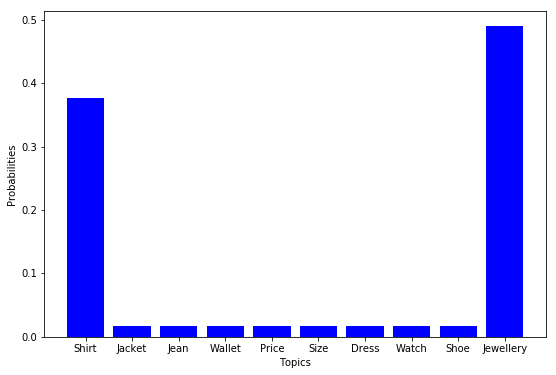

In [20]:
x_axis = [topic for topic, _ in lda_model.get_document_topics(bow_vector)]
print(x_axis)

y_axis = [prob for _, prob in lda_model.get_document_topics(bow_vector)]
print(y_axis)
topic_list=['Shirt','Jacket','Jean','Wallet','Price','Size','Dress','Watch','Shoe','Jewellery']

import matplotlib.pyplot as plt


fig,ax = plt.subplots()
ax.bar(x_axis, y_axis, color='b', tick_label = topic_list)

fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 9b
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.ylabel('Probabilities')
plt.xlabel('Topics')
plt.show()

# print(matplotlib.__version__)

In [81]:
mydict=dict(zip(y_axis, x_axis))


In [24]:
import warnings
warnings.filterwarnings("ignore")
from gensim.models import CoherenceModel


In [51]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs,dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.704952041706492

Coherence Score:  0.5514499082008167


### Visualizing Topics

In [15]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model10.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)


/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Visualizing TFIDF


In [54]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
ldatfidf = gensim.models.ldamodel.LdaModel.load('model10tfidf.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)



### Finding the most dominant topic in each sentence

In [21]:
def format_topics_sentences(ldamodel, texts,corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, texts=processed_docs,corpus=bow_corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.5566,"love, look, color, wear, like, nice, ring, gre...","[great, tutu, great, price, look, cheap, glad,..."
1,1,9.0,0.5790,"love, look, color, wear, like, nice, ring, gre...","[buy, daughter, danc, class, wear, today, time..."
2,2,9.0,0.7764,"love, look, color, wear, like, nice, ring, gre...","[daughter, orang, black, white, pink, think, f..."
3,3,6.0,0.3371,"like, wear, dress, look, littl, strap, comfort...","[buy, tutus, high, review, sturdi, seem, girl,..."
4,4,9.0,0.4457,"love, look, color, wear, like, nice, ring, gre...","[thank, halo, heaven, great, product, littl, g..."
5,5,9.0,0.3096,"love, look, color, wear, like, nice, ring, gre...","[receiv, today, daughter, think, puffier, look..."
6,6,4.0,0.5495,"price, order, qualiti, product, time, arriv, p...","[buy, backup, regular, ballet, outfit, daughte..."
7,7,9.0,0.6858,"love, look, color, wear, like, nice, ring, gre...","[great, tutu, great, price, high, qualiti, ski..."
8,8,6.0,0.4437,"like, wear, dress, look, littl, strap, comfort...","[daughter, like, costum, like, fuller]"
9,9,4.0,0.3968,"price, order, qualiti, product, time, arriv, p...","[pay, tutus, unbeat, order, pink, turquio, vib..."


3.0    11886
7.0    12844
1.0    14270
5.0    19660
2.0    20401
6.0    23019
4.0    28473
0.0    45476
9.0    46726
8.0    55922
Name: Dominant_Topic, dtype: int64


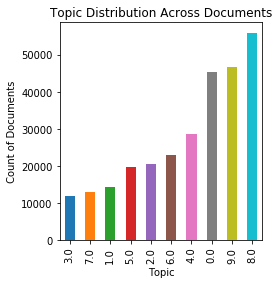

In [35]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts(ascending=True)
print(topic_counts)
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Topic')
ax1.set_ylabel(' Count of Documents ')
ax1.set_title("Topic Distribution Across Documents")
topic_counts.plot(kind='bar')

In [50]:
print(topic_counts.index)


Float64Index([3.0, 7.0, 1.0, 5.0, 2.0, 6.0, 4.0, 0.0, 9.0, 8.0], dtype='float64')


In [53]:
topic_list= ['Wallet','Watch','Jacket','Size','Jean','Dress','Price','Shirt','Jewelery','Shoe']

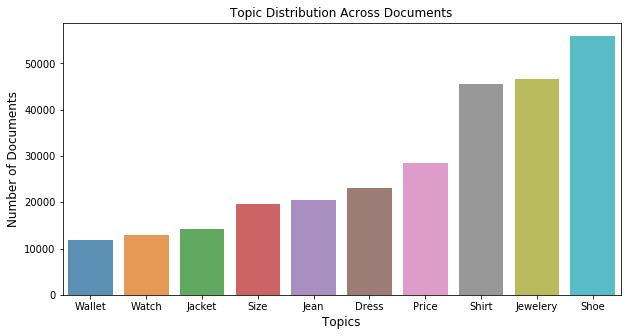

In [54]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(topic_list, topic_counts.values, alpha=0.8)
plt.title('Topic Distribution Across Documents')
plt.ylabel('Number of Documents', fontsize=12)
plt.xlabel('Topics', fontsize=12)
plt.show()

In [36]:
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
print(topic_contribution)


3.0    0.0427
7.0    0.0461
1.0    0.0512
5.0    0.0705
2.0    0.0732
6.0    0.0826
4.0    0.1022
0.0    0.1632
9.0    0.1677
8.0    0.2007
Name: Dominant_Topic, dtype: float64
